In [1]:
import pandas as pd
import Experiment_calculus as exca
import Experiment_FDA as exda

# Adjust pandas options to see all columns and to read subgroup descriptions fully
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', 200)

In [2]:
exda.main() 

Collected 50 subgroup models.
Exported 50 subgroup models to results/subgroup_linear_models.csv
Complex baseline evaluation metrics: {'r2': 0.1428, 'mae': np.float64(0.8974), 'mse': np.float64(1.3404), 'mean_residual': -0.0965, 'y_pred': 413    7.173249
955    7.574448
601    7.085345
593    4.687878
816    7.748823
654    6.961026
489    7.066269
452    6.741941
155    4.782092
879    7.202394
696    5.910122
744    5.890880
520    7.086891
244    7.435708
247    6.975492
321    6.201849
380    7.878398
260    7.475106
299    6.289569
495    7.092890
358    7.060088
752    6.880192
214    6.506578
482    4.322289
88     6.278090
152    6.775834
441    8.121396
574    6.825939
661    6.834298
595    6.704929
650    6.854041
72     7.034992
775    7.562938
357    7.857402
704    6.069019
462    6.838923
425    7.318524
867    6.995857
236    7.371722
538    7.210595
611    7.275387
47     7.575830
852    7.077944
759    7.763550
904    8.080396
221    6.359788
986    7.754473
40     6.5

In [3]:
df_s = pd.read_csv("results/subgroup_model_results_data-analytics.csv")
df_s = df_s[:50]
df_s.head(1)
#df_s.columns

,r2,mae,mse,mean_residual,intercept,coef__total_attended_labsessions,pval__total_attended_labsessions,coef__active_minutes,pval__active_minutes,coef__nr_distinct_files_viewed,pval__nr_distinct_files_viewed,coef__total_course_activities,pval__total_course_activities,coef__distinct_days,pval__distinct_days,coef__nr_files_viewed,pval__nr_files_viewed,coef__nr_practice_exams_viewed,pval__nr_practice_exams_viewed,model_type,description,cookD,n_train,n_test,global_baseline_r2,global_baseline_mae,global_baseline_mse,global_baseline_mean_residual,mean_baseline_r2,mean_baseline_mae,mean_baseline_mse,mean_baseline_mean_residual,ttest_p,ttest_stat,wilcoxon_p,wilcoxon_stat,ttest_p_mean,ttest_stat_mean,wilcoxon_p_mean,wilcoxon_stat_mean,ttest_p_mean_global,ttest_stat_mean_global,wilcoxon_p_mean_global,wilcoxon_stat_mean_global
0,0.3604,0.9268,1.5464,0.3014,2.376621,-0.089653,0.426214,-0.000012,0.800176,0.040404,0.461445,0.009357,0.295204,0.025404,0.589199,-0.040769,0.290951,0.033724,0.651535,subgroup,"GPA in (1.2990000000000002, 5.6] ∧ origin=='ORIGIN_E'",158.380886,70,14,-0.2154,1.2491,2.9385,-1.1667,-0.052334,1.292041,2.544339,0.355714,0.101124,-1.343006,0.178772,37.0,0.013036,-2.510425,0.014771,18.0,0.61882,0.308808,0.5,52.0


In [4]:
# Assign rank: one per row (since you now have only subgroup_model rows)
df_s['subgroup_rank'] = (df_s.index + 1).astype("object")
df_s.loc[df_s['model_type'] == 'global', 'subgroup_rank'] = "N/A"

# Round columns for better readability
for col, ndigits in [('cookD', 2), ('r2', 3), ('mae', 3), ('mse', 3), ('mean_residual', 3),
                     ('global_baseline_r2', 3), ('global_baseline_mae', 3), ('global_baseline_mse', 3), ('global_baseline_mean_residual', 3),
                     ('mean_baseline_r2', 3), ('mean_baseline_mae', 3), ('mean_baseline_mse', 3), ('mean_baseline_mean_residual', 3)]:
    if col in df_s.columns:
        df_s[col] = df_s[col].round(ndigits)

# Compare r2 between subgroup_model and global baseline for each row
df_s['subgroup_r2_better'] = (df_s['r2'] > df_s['global_baseline_r2']).astype("object")
df_s.loc[df_s['model_type'] == 'global', 'subgroup_r2_better'] = None
df_s['subgroup_better_global'] = (df_s['ttest_p'] < 0.1)
df_s.loc[df_s['model_type'] == 'global', 'subgroup_better_global'] = None
df_s['subgroup_better_mean'] = (df_s['ttest_p_mean'] < 0.1)
df_s.loc[df_s['model_type'] == 'global', 'subgroup_better_mean'] = None
df_s['global_better_mean'] = (df_s['ttest_p_mean_global'] < 0.1)
df_s.loc[df_s['model_type'] == 'global', 'global_better_mean'] = None

# Add decision column based on the rules
def determine_decision(row):
    sg = row['subgroup_better_global']
    sm = row['subgroup_better_mean']
    gm = row['global_better_mean']
    
    if sg and sm:
        return "True discovery"
    elif sg and not sm:
        return "True discovery, but model not appropriate"
    elif not sg and sm:
        return "Weak discovery"
    elif not sg and not sm and gm:
        return "False discovery"
    else:
        return "Model not appropriate"

df_s['decision'] = df_s.apply(determine_decision, axis=1)

# Specify desired column order
main_cols = [
    'subgroup_rank', 'model_type', 'description', 'decision', 'subgroup_r2_better', 'cookD', 'n_train', 'n_test',
    'r2', 'global_baseline_r2', 'mean_baseline_r2', 
    'mae', 'global_baseline_mae', 'mean_baseline_mae',
    'mse', 'global_baseline_mse', 'mean_baseline_mse',
    'mean_residual', 'global_baseline_mean_residual', 'mean_baseline_mean_residual'
]
rest_cols = [c for c in df_s.columns if c not in main_cols]
new_order = main_cols + rest_cols

# Reorder columns
df_s = df_s[new_order]

/var/folders/0_/xw_ks0g978df8kf5jp1rvf2h0000gn/T/ipykernel_16440/2205722591.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_s.loc[df_s['model_type'] == 'global', 'subgroup_better_global'] = None
/var/folders/0_/xw_ks0g978df8kf5jp1rvf2h0000gn/T/ipykernel_16440/2205722591.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_s.loc[df_s['model_type'] == 'global', 'subgroup_better_mean'] = None
/var/folders/0_/xw_ks0g978df8kf5jp1rvf2h0000gn/T/ipykernel_16440/2205722591.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with

In [5]:
df_s[df_s['decision'].isin(['True discovery'])][['subgroup_rank', 'description', 'decision', 'n_test', 'n_train', 'cookD', 'r2', 'global_baseline_r2', 'mean_baseline_r2']]

,subgroup_rank,description,decision,n_test,n_train,cookD,r2,global_baseline_r2,mean_baseline_r2
5,6,"GPA in (7.0, 8.9] ∧ origin=='ORIGIN_E'",True discovery,21,91,113.61,0.200,-0.689,-0.033
6,7,"GPA in (7.0, 8.9] ∧ course_repeater==np.False_ ∧ origin=='ORIGIN_E'",True discovery,21,91,113.61,0.200,-0.689,-0.033
7,8,"ECTS=='15' ∧ GPA in (7.0, 8.9]",True discovery,40,145,113.00,0.104,-0.792,-0.052
8,9,"ECTS=='15' ∧ GPA in (7.0, 8.9] ∧ course_repeater==np.False_",True discovery,40,145,113.00,0.104,-0.792,-0.052
9,10,"GPA in (7.0, 8.9]",True discovery,47,185,112.17,0.027,-0.510,-0.114
10,11,"GPA in (7.0, 8.9] ∧ course_repeater==np.False_",True discovery,47,185,112.17,0.027,-0.510,-0.114
11,12,"ECTS=='15' ∧ GPA in (7.0, 8.9] ∧ origin=='ORIGIN_E'",True discovery,19,78,111.71,0.187,-0.779,-0.033
42,43,croho=='B Industrial Design',True discovery,30,123,36.57,0.186,-0.330,-0.132


In [12]:
df_s[df_s['decision'].isin(['Model not appropriate'])][['subgroup_rank', 'description', 'decision', 'n_test', 'cookD', 'r2', 'global_baseline_r2']]

,subgroup_rank,description,decision,n_test,cookD,r2,global_baseline_r2
1,2,"ECTS=='15' ∧ GPA in (7.0, 8.9] ∧ croho=='B Computer Science & Engineering'",Model not appropriate,23,118.78,-0.208,-1.045
12,13,"GPA in (7.0, 8.9] ∧ sex=='SEX_M'",Model not appropriate,27,111.28,-0.058,-0.770
13,14,"GPA in (7.0, 8.9] ∧ course_repeater==np.False_ ∧ sex=='SEX_M'",Model not appropriate,27,111.28,-0.058,-0.770
14,15,"GPA in (7.0, 8.9] ∧ origin=='ORIGIN_E' ∧ sex=='SEX_M'",Model not appropriate,9,110.45,-0.185,-1.402
19,20,"GPA in (1.2990000000000002, 5.6] ∧ origin=='ORIGIN_N' ∧ sex=='SEX_M'",Model not appropriate,17,84.49,-0.811,-0.419
23,24,"GPA in (1.2990000000000002, 5.6] ∧ origin=='ORIGIN_N'",Model not appropriate,24,67.76,-0.273,-0.538
24,25,"ECTS=='15' ∧ GPA in (6.3, 7.0]",Model not appropriate,23,66.08,-0.342,-0.045
25,26,"ECTS=='15' ∧ GPA in (6.3, 7.0] ∧ course_repeater==np.False_",Model not appropriate,23,66.08,-0.342,-0.045
26,27,"GPA in (1.2990000000000002, 5.6] ∧ course_repeater==np.False_ ∧ origin=='ORIGIN_N'",Model not appropriate,21,66.03,-0.199,-0.767
27,28,ECTS=='15' ∧ sex=='SEX_V',Model not appropriate,26,57.93,-0.026,0.170


In [7]:
df_s['decision'].value_counts()

decision
Model not appropriate                        19
True discovery, but model not appropriate    15
Weak discovery                                8
True discovery                                8
Name: count, dtype: int64

In [15]:
df = pd.read_csv('results/coefs_data-analytics.csv')

# Create display labels: #1, #2, ...
chosen = [6, 8, 10, 12, 43]#[5, 7, 16, 27]#[5, 7, 16, 27, 37, 40, 42, 44]##


df_lins = df[df['subgroup'].isin(['#'+str(i) for i in chosen] + ['Ω'])]

df_lins = df_lins[df_lins['term'] != 'const']

df_s[df_s['subgroup_rank'].isin(chosen )][['subgroup_rank', 'description', 'decision', 'cookD', 'r2', 'global_baseline_r2', 'n_test']]

,subgroup_rank,description,decision,cookD,r2,global_baseline_r2,n_test
5,6,"GPA in (7.0, 8.9] ∧ origin=='ORIGIN_E'",True discovery,113.61,0.200,-0.689,21
7,8,"ECTS=='15' ∧ GPA in (7.0, 8.9]",True discovery,113.00,0.104,-0.792,40
9,10,"GPA in (7.0, 8.9]",True discovery,112.17,0.027,-0.510,47
11,12,"ECTS=='15' ∧ GPA in (7.0, 8.9] ∧ origin=='ORIGIN_E'",True discovery,111.71,0.187,-0.779,19
42,43,croho=='B Industrial Design',True discovery,36.57,0.186,-0.330,30


42 49


/var/folders/0_/xw_ks0g978df8kf5jp1rvf2h0000gn/T/ipykernel_16440/2675758831.py:19: UserWarning: The palette list has more values (16) than needed (7), which may not be intended.
  ax = sns.barplot(


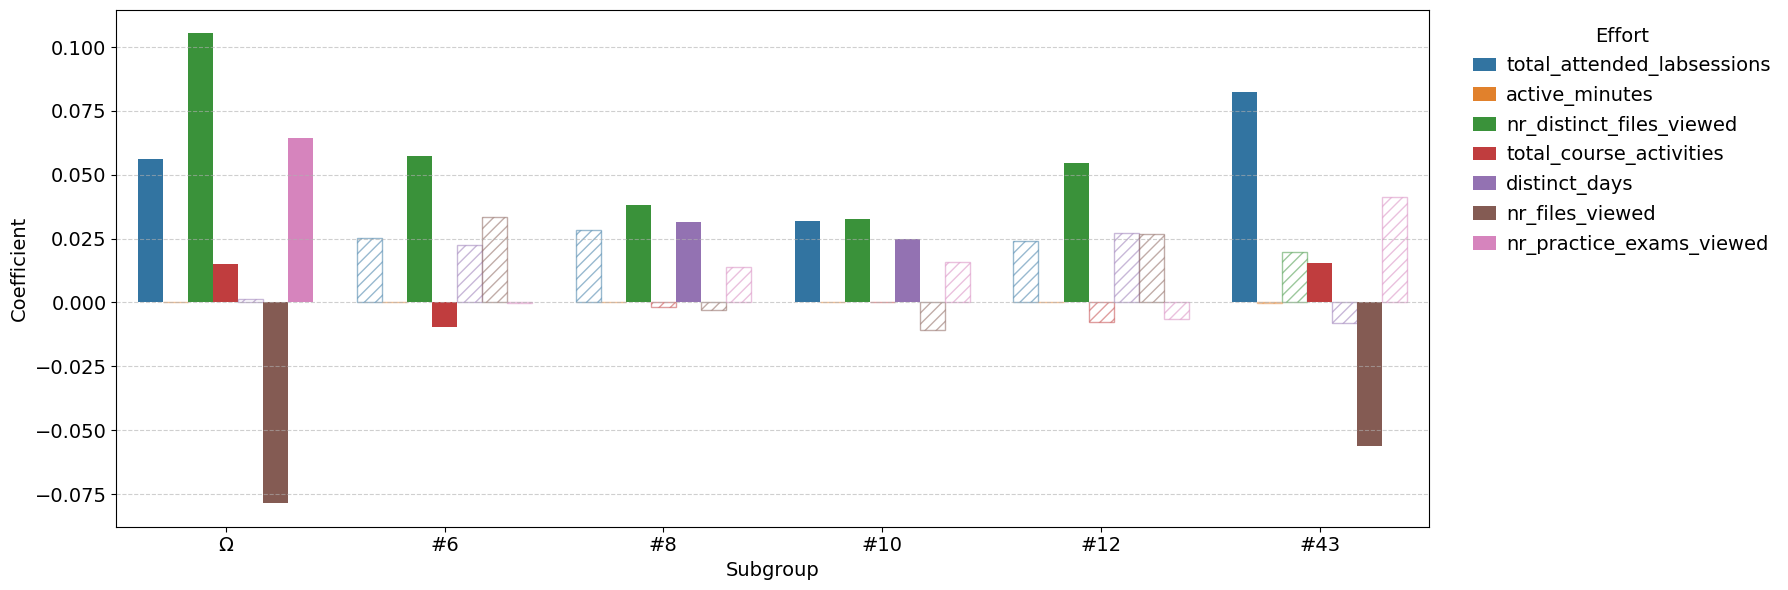

In [16]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from matplotlib.patches import Patch


#####
# To DO: Change bar fill depending on significant, yes or no 
#####

palette = sns.color_palette("tab10", 16)
#palette = random.shuffle(palette)
plt.figure(figsize=(18, 6))

df = df_lins#[ df_all['term'] != 'Intercept']

ax = sns.barplot(
    data=df,
    x="subgroup",
    y="coef",
    hue="term",
    dodge=True,
    palette=palette
)
patches_sorted = sorted(ax.patches[:-7], key=lambda p: p.get_x())
print(len(df_lins['significant']), len(ax.patches))
for patch, sig in zip(patches_sorted, df_lins['significant']):
    if sig == 'no':
        patch.set_hatch("///")      # striped fill
        patch.set_edgecolor(patch.get_facecolor())  # keep original color for stripes
        patch.set_facecolor("white")  # base color for hatch
        patch.set_alpha(0.5)
#     # sig == 1 → leave as solid color

ax.set_xlabel("Subgroup", fontsize=14)
ax.set_ylabel("Coefficient", fontsize=14)

# Grid (clean style)how 
ax.yaxis.grid(True, linestyle="--", alpha=0.6)
ax.xaxis.grid(False)
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)

# # Legend outside
# # Smaller legend outside the plot
ax.legend(

    title="Effort",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    fontsize=14,          # legend text size
    title_fontsize=14,    # legend title size
    frameon=False,       # cleaner look
    handlelength=1.2,
    handletextpad=0.5
)
# Custom legend
# Color legend for terms
terms = df_lins["term"].unique()
palette = sns.color_palette("tab10", len(terms))
color_handles = [Patch(facecolor=palette[i], label=term) for i, term in enumerate(terms)]

# # # Hatch legend for significance
sig_handles = [
    Patch(facecolor="white", edgecolor="black", hatch="///", label="not significant"),
    Patch(facecolor="black", edgecolor="black", label="significant")
]

# Combine legends first_legend = ax.legend(handles=color_handles, title="Term", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8, title_fontsize=9) ax.add_artist(first_legend) ax.legend(handles=sig_handles, title="Significance", bbox_to_anchor=(1.02, 0.6), loc="upper left", fontsize=8, title_fontsize=9)

plt.tight_layout()
plt.show()